<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [ ]:
# if local
!conda activate cs685

/bin/bash: conda: command not found


In [ ]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [ ]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'
    DATA_PATH = r'C:\Users\faria\PycharmProjects\685\project\data\implicit-hate-corpus-nov-2021\implicit-hate-corpus'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [ ]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [ ]:
# !git status

install requirements from repo 

In [ ]:
# for colab, use venv if in local
!pip install -r requirements.txt

     |████████████████████████████████| 4.0 MB 9.4 MB/s 
     |████████████████████████████████| 1.8 MB 37.5 MB/s 
     |████████████████████████████████| 895 kB 44.6 MB/s 
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 6.6 MB 32.1 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 181 kB 51.9 MB/s 
     |████████████████████████████████| 144 kB 40.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=acce194b10f9eb15dd849fc1550eed5b108cce7953a32057fbe4a768b17180da
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


load the helper and dataloader files

In [ ]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [ ]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [ ]:
import os

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [ ]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

implicit_hate_dataset = Stage2Dataset(dataset_filename["stage-2"], drop_other=True)

labels = implicit_hate_dataset.implicit_classes
# splitting into train and test set
train_idx, test_idx= train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels)
print(len(labels), len(train_idx), len(test_idx))
train_idx.sort()
print(np.arange(len(labels)))
print(train_idx)

# splitting into train and val set from train indices 
train_labels = list(map(labels.__getitem__, train_idx))
train_idx, val_idx= train_test_split(train_idx, test_size=0.25, shuffle=True, stratify=train_labels)
print(len(train_idx), len(val_idx))

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

# test_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=test_sampler)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

6266 5012 1254
[   0    1    2 ... 6263 6264 6265]
[   0    1    2 ... 6262 6263 6265]
3759 1253


In [ ]:
# Confirming type is tensor
_, _, _, input_ids, attention_masks, labels, _ = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_idx, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    validation_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=sampler)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[3]
      input_mask_tensors = batch[4]
      label_tensors = batch[5]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_idx)
    final_score = precision_recall_fscore_support(predicted, labels, average='macro')
    class_names=['white_grievance', 'incitement', 'inferiority', 'irony', 'stereotypical', 'threatening']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1, 2, 3, 4, 5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [ ]:
!wandb login 

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

# sweep_config = {
#     "name": "original-ppr-hparams-sweep",
#     "method" : "grid",
#     "parameters" : {
#         "batch_size": {
#             "values" : [8]
#         },
#         "learning_rate" : {
#             "values": [5e-5]
#         },
#         "epochs" : {
#             "values" : [1]
#         },
#         "epsilon": {
#             "values" : [1e-8]
#         },
#     }
# }


# hyperparameters used in original paper
sweep_config = {
    "name": "original-ppr-hparams-sweep",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [2e-5, 3e-5, 5e-5]
        },
        "epochs" : {
            "values" : [1, 2, 3, 4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: 36b0ikdn
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/36b0ikdn


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 6, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[3]
                input_mask_tensors = batch[4]
                label_tensors = batch[5]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_idx, config, epoch_i, "val")
            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(model, test_idx, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: xu324nbu with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: Currently logged in as: psarda (use `wandb login --relogin` to force relogin)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...
Total loss: 645.261355638504


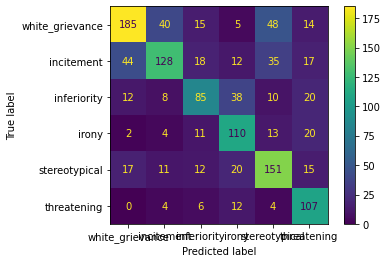

0.6263375369918045 0.6062506418939823 0.6077957734841186
Validation accuracy: 0.6113328012769353

Training complete!


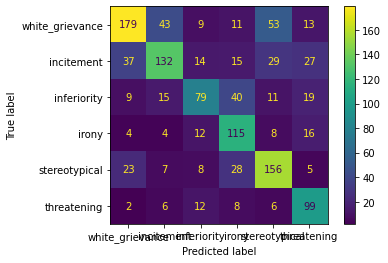

0.6187262135822627 0.6013567073267027 0.6012314959272308
Test accuracy: 0.6060606060606061


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▇▇▇▇▇▆██▅▇▆▇▆▇▅▅▆▄▇▄▃▆▃▆▅▄▂▅▄▆▃▄▄▄▃▆▅▁▅▁
epoch,▁
loss,▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁
val_f1,▁
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4q0dfkf5 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...
Total loss: 633.603136330843


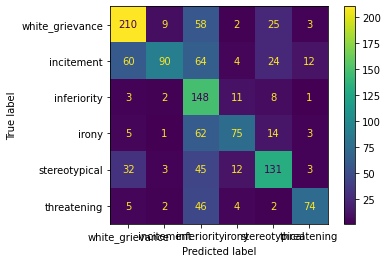

0.5831080202052988 0.6608507665344922 0.5809654065054555
Validation accuracy: 0.5810055865921788

Training complete!


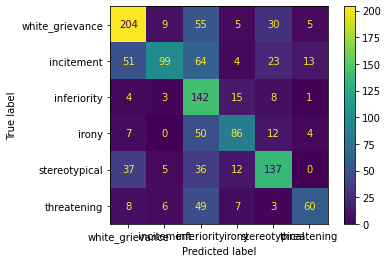

0.5780738736980918 0.6431267571118707 0.576724947627616
Test accuracy: 0.580542264752791


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▆▇▆█▇▇█▇▄▅▄▅▆▆▅▃▄▄▂▆▅▄▃▆▄▆▃▄▆▅█▃▄▃▃▄▂▁▅▅
epoch,▁
loss,▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁
val_f1,▁
val_precision,▁


wandb: Agent Starting Run: cltyvmlk with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...
Total loss: 615.5677499473095


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


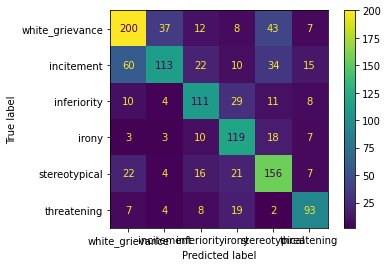

0.6452049653242706 0.6357704971552054 0.6337954249750344
Validation accuracy: 0.6320830007980845

Training complete!


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


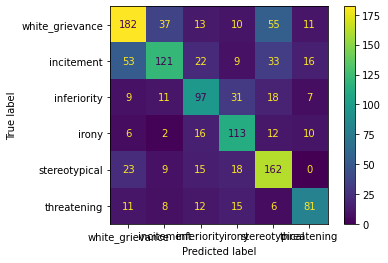

0.6102252422065066 0.604951997443885 0.602658847312057
Test accuracy: 0.6028708133971292


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▆██▆▆▇▆▆▅▃▆▁▅▆▅▆▆▅▇▂▂▅▃▃▂▅▃▃▄▅▃▄▃▄▆▂▂▆▃▁
epoch,▁
loss,▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁
val_f1,▁
val_precision,▁


wandb: Agent Starting Run: 8glqyz2b with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
Total loss: 634.6412813067436


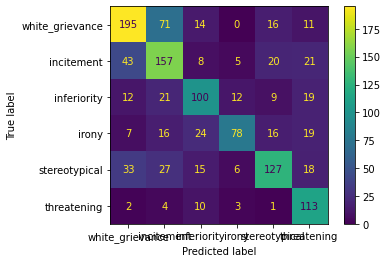

0.6217325057001838 0.6278592788174925 0.6138322619860789
Validation accuracy: 0.6145251396648045

======== Epoch 2 / 2 ========
Training...
Total loss: 407.14421294629574


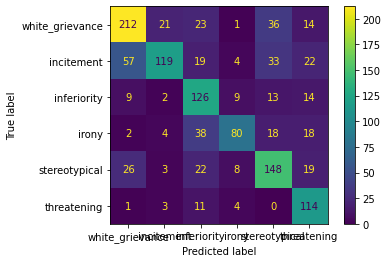

0.6498985826897006 0.6532167482125082 0.6328370319490061
Validation accuracy: 0.6376695929768555

Training complete!


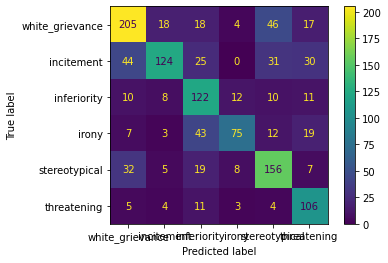

0.6358151613525292 0.6416850423922803 0.6223156016999567
Test accuracy: 0.6283891547049442


batch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch_loss,▇▇▇█▅▅▅▇▆▅▅▅▄▆█▄▄▆▇▂▃▃▄▅▄▃▇▁▄▃▃▃▃▆▂▅▂▁▄▃
epoch,▁▁
loss,█▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█
val_f1,▁█
val_precision,▁█


wandb: Agent Starting Run: 3w6a5gbh with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
Total loss: 612.6118995547295


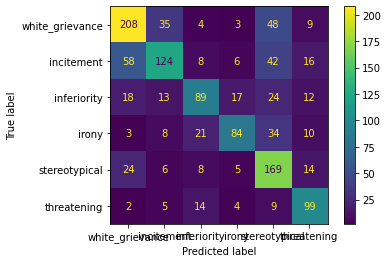

0.6162187977120851 0.6291407028953523 0.6133371007680753
Validation accuracy: 0.6169193934557063

======== Epoch 2 / 2 ========
Training...
Total loss: 382.24230118095875


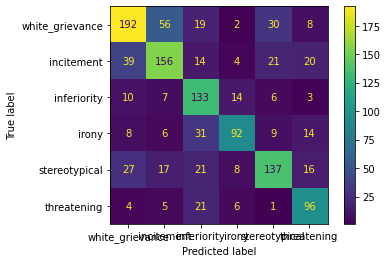

0.6518942871969245 0.6478284857489698 0.6441990391808164
Validation accuracy: 0.6432561851556265

Training complete!


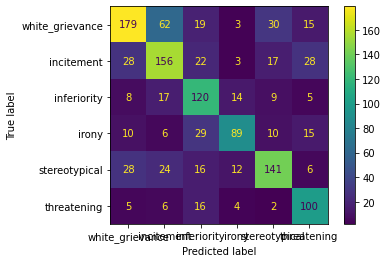

0.6369595298971356 0.6313903118778713 0.6283651157919908
Test accuracy: 0.6259968102073366


batch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch_loss,█▇▇▇▆▅▄▄▅▇▆▄▅▆▇▅▄▅▅▇▂▃▂▁▇▄▃▃▄▃▄▄▅▂▃▄▃▁▄▂
epoch,▁▁
loss,█▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█
val_f1,▁█
val_precision,▁█


wandb: Agent Starting Run: 3bhnl7ve with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
Total loss: 634.0691891610622


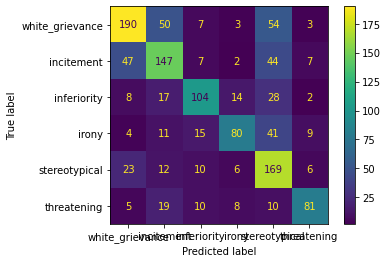

0.6092664836663744 0.6477136329728541 0.6190635294453756
Validation accuracy: 0.6153232242617718

======== Epoch 2 / 2 ========
Training...
Total loss: 385.0393627882004


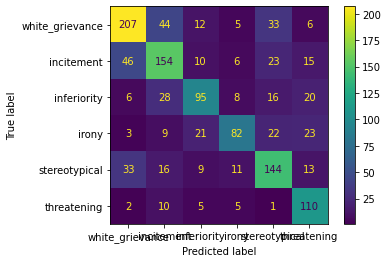

0.6344058453863924 0.6339347443948894 0.627836116843543
Validation accuracy: 0.6320830007980845

Training complete!


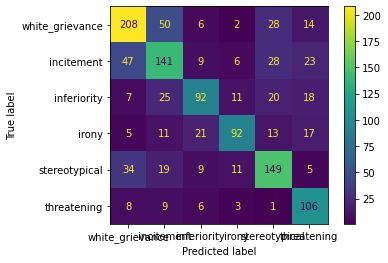

0.6323718652796416 0.6346838189039959 0.6281324183708583
Test accuracy: 0.6283891547049442


batch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch_loss,███▇▅▆▆▇▅▇▄▆▇▆▆▆▇▅▅▃▃▁▄▃▅▂▄▄▆▇▂▁▃▄▁▃▃▅▆▃
epoch,▁▁
loss,█▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█
val_f1,▁█
val_precision,▁█


wandb: Agent Starting Run: j69wbf51 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
Total loss: 630.4627270102501


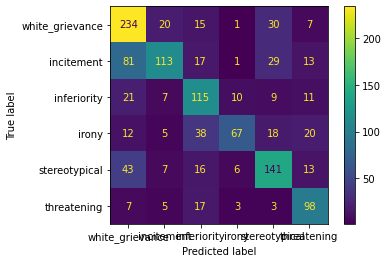

0.6085537780738485 0.6357588739052765 0.6041823066313717
Validation accuracy: 0.6129289704708699

======== Epoch 2 / 3 ========
Training...
Total loss: 394.99296559393406


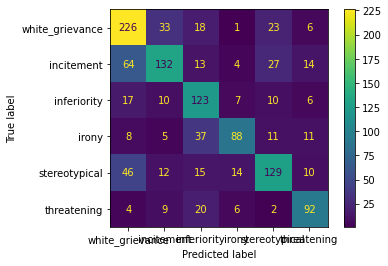

0.6298916389344015 0.6423266643382404 0.6295376560577943
Validation accuracy: 0.6304868316041501

======== Epoch 3 / 3 ========
Training...
Total loss: 221.97045478597283


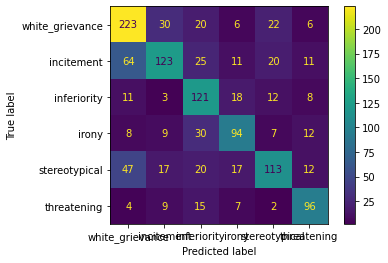

0.6198938016534831 0.61848865772919 0.6128301918531059
Validation accuracy: 0.6145251396648045

Training complete!


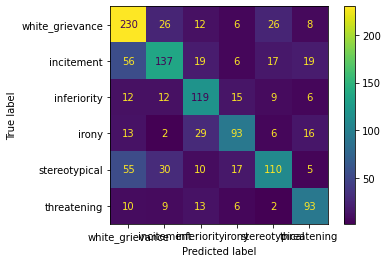

0.623786645940862 0.6275219721522458 0.6207493225432352
Test accuracy: 0.6236044657097288


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,█▆█▅▆▆▅▆▇▆▆▅▃▄▄▂▅▅▂▃▂▅▄▂▄▆▂▃▂▁▃▁▁▂▂▅▁▄▂▂
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▂
val_f1,▁█▃
val_precision,▁█▅


wandb: Agent Starting Run: sqd4d6a1 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
Total loss: 627.0242946147919


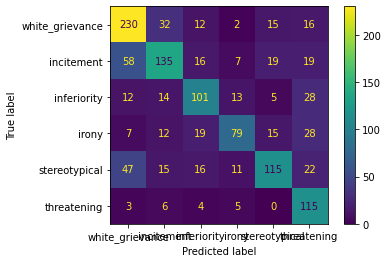

0.6219596618839608 0.6227270522790096 0.608644039054794
Validation accuracy: 0.6185155626496409

======== Epoch 2 / 3 ========
Training...
Total loss: 386.6144448518753


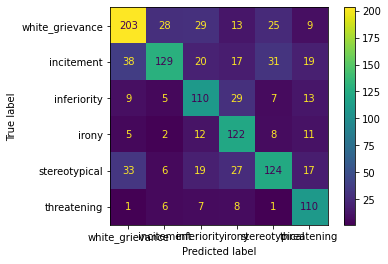

0.6571983644329915 0.6342908901675235 0.6362574581242207
Validation accuracy: 0.6368715083798883

======== Epoch 3 / 3 ========
Training...
Total loss: 194.4659999385476


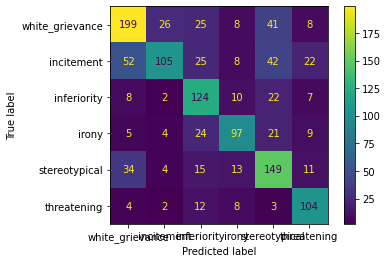

0.6376423707039416 0.6333103849632978 0.6237539898616298
Validation accuracy: 0.6209098164405427

Training complete!


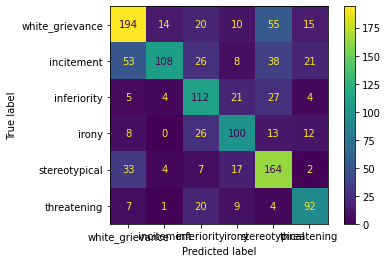

0.6242654875775372 0.6304913209145558 0.6134207448039745
Test accuracy: 0.6140350877192983


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,█▇█▅▇▅▅█▅▅▄▃█▄▄▂▄▅▃▄▃▆▁▃▄▅▃▅▂▄▁▃▄▄▄▄▁▂▃▁
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▂
val_f1,▁█▅
val_precision,▁█▄


wandb: Agent Starting Run: 1giqlmcm with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
Total loss: 631.7388747036457


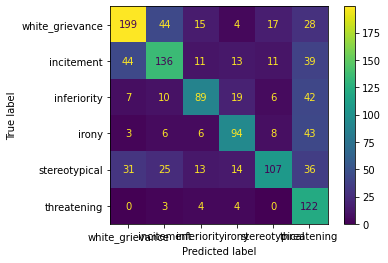

0.6127228279149791 0.6165964910546484 0.5911110207895224
Validation accuracy: 0.596169193934557

======== Epoch 2 / 3 ========
Training...
Total loss: 399.6726880669594


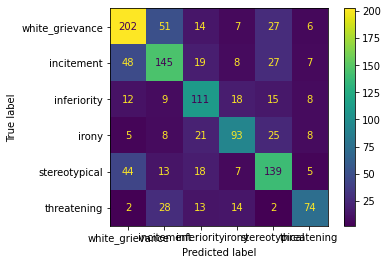

0.6038583866832313 0.6153146154328176 0.6078521689289731
Validation accuracy: 0.6097366320830008

======== Epoch 3 / 3 ========
Training...
Total loss: 202.44596096873283


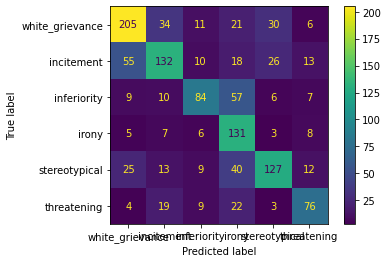

0.6041853482330395 0.6115340006702433 0.5957075171761728
Validation accuracy: 0.6025538707102953

Training complete!


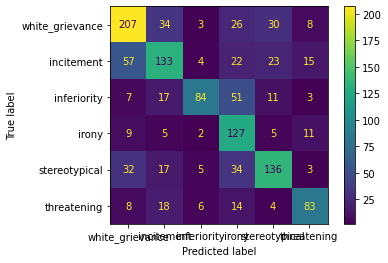

0.6171950556236652 0.6395559014406844 0.6135191685374627
Test accuracy: 0.6140350877192983


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▇█▅▇▆█▅▇▅▆▆▄▃▃▄▃▄▅▆▆▇▃▂▃▆▂▂▂▂▂▁▃▅▆▂▁▃▃▃
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▄
val_f1,▁█▃
val_precision,█▁▁


wandb: Agent Starting Run: g1qb2e57 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 639.207578510046


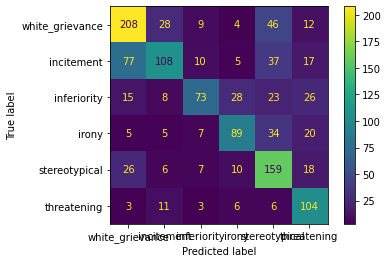

0.5944052180845162 0.6031787486357877 0.5832632050813553
Validation accuracy: 0.5913806863527534

======== Epoch 2 / 4 ========
Training...
Total loss: 410.8083596229553


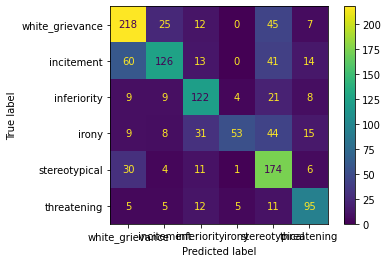

0.6211350404741521 0.6652898751220708 0.6164142356870267
Validation accuracy: 0.6288906624102155

======== Epoch 3 / 4 ========
Training...
Total loss: 235.68120276927948


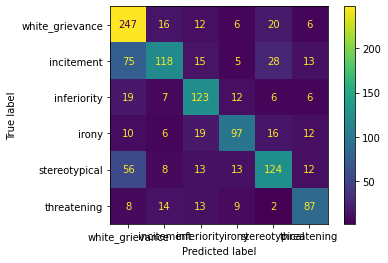

0.6315279588995435 0.6466053901430883 0.6312517314520661
Validation accuracy: 0.6352753391859537

======== Epoch 4 / 4 ========
Training...
Total loss: 122.76564117707312


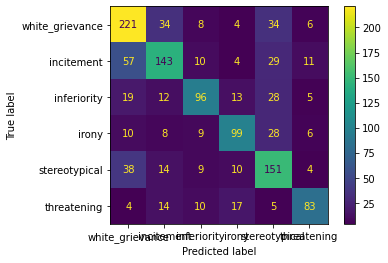

0.6247878118197707 0.6481915238690147 0.6329136552566714
Validation accuracy: 0.6328810853950518

Training complete!


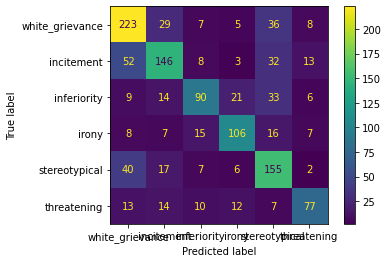

0.6245822926421228 0.646044144434397 0.6314778267910254
Test accuracy: 0.6355661881977671


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▆█▅▅▆▇▆▅▄▅▂▃▂▆▄▅▆▄▂▃▆▃▃▄▃▂▂▄▁▁▂▁▃▃▄▁▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▇██
val_f1,▁▆██
val_precision,▁▆█▇


wandb: Agent Starting Run: 53pc2urr with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 637.1251438856125


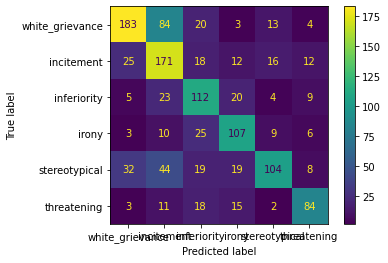

0.6128707223529865 0.6249186506015195 0.6099834960743215
Validation accuracy: 0.6073423782920989

======== Epoch 2 / 4 ========
Training...
Total loss: 383.85952919721603


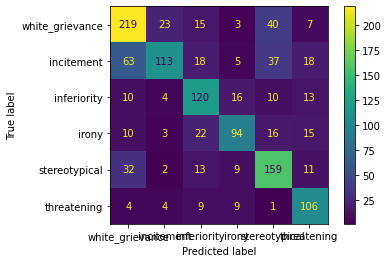

0.6566518102221136 0.6557873219434829 0.6456040518922689
Validation accuracy: 0.6472466081404629

======== Epoch 3 / 4 ========
Training...
Total loss: 191.17771331220865


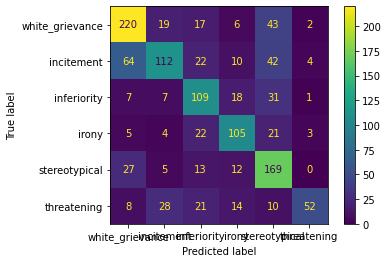

0.597105019572771 0.6414749556385494 0.598858741179647
Validation accuracy: 0.6121308858739026

======== Epoch 4 / 4 ========
Training...
Total loss: 96.07503277435899


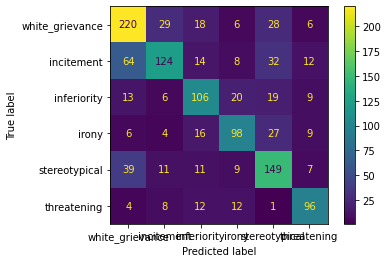

0.6351857773183869 0.6382047493227093 0.6331120820945951
Validation accuracy: 0.6328810853950518

Training complete!


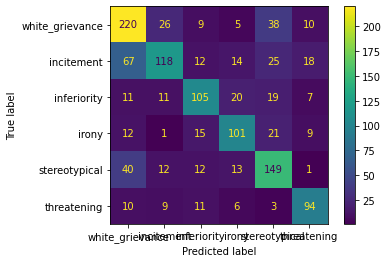

0.6306939613136963 0.6356357540498195 0.6290076163689343
Test accuracy: 0.6275917065390749


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,▇▇▇█▄▄▅▇▅▅▂▃▂▄▄▄▄▄▅▃▂▂▂▃▃▃▁▁▃▂▁▃▁▁▁▃▁▂▁▃
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▂▅
val_f1,▃█▁▆
val_precision,▃█▁▅


wandb: Agent Starting Run: z7hk574r with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 628.2161093354225


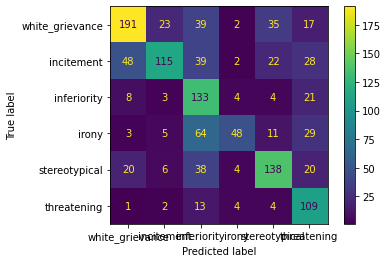

0.5956433685033319 0.6234987851312802 0.5706966149978471
Validation accuracy: 0.5857940941739824

======== Epoch 2 / 4 ========
Training...
Total loss: 401.3053001612425


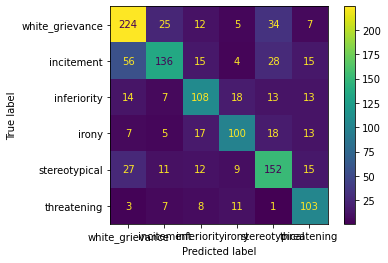

0.6602257805385993 0.6558877061829926 0.6540023457171339
Validation accuracy: 0.6568236233040702

======== Epoch 3 / 4 ========
Training...
Total loss: 225.43704207614064


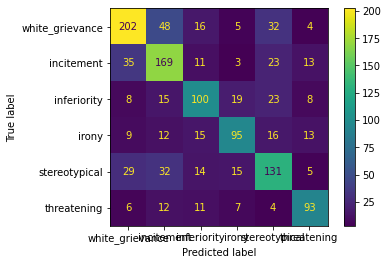

0.6290022678025853 0.6333613403103519 0.6303296448706446
Validation accuracy: 0.6304868316041501

======== Epoch 4 / 4 ========
Training...
Total loss: 118.29411241412163


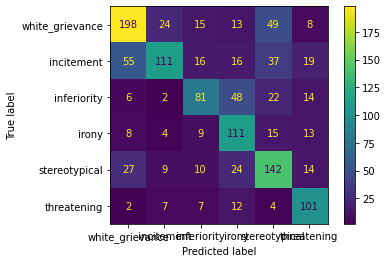

0.6052723644796403 0.5973219502262306 0.5897498784630201
Validation accuracy: 0.5937749401436552

Training complete!


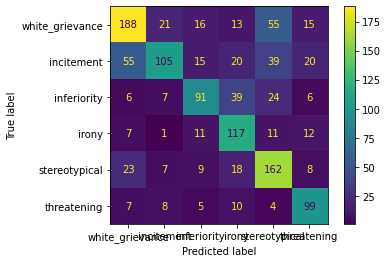

0.6239422240632527 0.6146935520421303 0.6069394072006818
Test accuracy: 0.6076555023923444


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,▇▇▆▇▆▇▅█▄▄▂▆▅▃▆▄▃▂▃▄▃▂▃▃▄▄▄▃▁▂▁▂▁▁▂▂▁▁▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▅▂
val_f1,▁█▆▃
val_precision,▁█▅▂


In [ ]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")